In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import joblib
from sklearn.metrics import mean_squared_error

In [38]:
df_1 = pd.read_csv("/content/CPI.csv")
df_2 = pd.read_csv("/content/GDP.csv")
df_3 = pd.read_csv("/content/MSACSR.csv") #money supply of household:MSACSR
df_4 = pd.read_csv("/content/PPI.csv")
df_5 = pd.read_csv("/content/home_price.csv")
df_6 = pd.read_csv("/content/mortgage.csv")
df_7 = pd.read_csv("/content/real_interest_rate.csv")
df_urate=pd.read_csv("/content/u_rate.csv") #unemployment rate:u_rate
df_population=pd.read_csv("/content/population.csv")
df =  pd.read_csv("/content/med_inc.csv")  #median income: med_inc


In [39]:
#calculation to create database of mortgage,gdp,med_inc

#mortgage----

df_6['DATE'] = pd.to_datetime(df_6['DATE'], format='%m/%d/%Y')

# Extract the month and year from the date column
df_6['month_year'] = df_6['DATE'].dt.to_period('M')

# Group by month and year and calculate the average mortgage amount
df_m = df_6.groupby('month_year')['MORTGAGE30US'].mean().reset_index()

# Convert the period to a string in 'YYYY-MM' format
df_m['month_year'] = df_m['month_year'].astype(str)

# Rename columns
df_m.columns = ['month_year', 'average_mortgage_amount']

#######


new_row = {'month_year': "2024-03"	, 'average_mortgage_amount': 6.7970}

# Add new row at the end
df_m.loc[len(df_m)] = new_row

###
#gdp-----

# Load the GDP data
gdp = pd.read_csv('/content/GDP.csv', parse_dates=['DATE'])


# Initialize a list to hold the new rows
new_rows = []
new_dates = []

# Repeat each row three times with updated dates
for i in range(len(gdp)):
    for j in range(3):
        new_rows.append(gdp.iloc[i].copy())
        new_date = gdp['DATE'].iloc[i] + pd.DateOffset(months=j)
        new_dates.append(new_date)

# Create a new DataFrame with the repeated rows and new dates
gdp_repeated = pd.DataFrame(new_rows)
gdp_repeated['DATE'] = new_dates

# Sort the DataFrame by date to ensure chronological order
gdp_repeated.sort_values('DATE', inplace=True)

# Set the new 'DATE' column as the index
gdp_repeated.set_index('DATE', inplace=True)

####
df_gdp = gdp_repeated.iloc[2:].reset_index(drop=True)


####
#med_inc----

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Generate the complete range of monthly dates from March 2004 to March 2024
monthly_dates = pd.date_range(start='2004-03-01', end='2024-03-01', freq='MS')

# Create a new DataFrame with the monthly dates
monthly_df = pd.DataFrame({'Date': monthly_dates})
monthly_df.set_index('Date', inplace=True)

# Create a DataFrame to hold the monthly interpolated values
extended_df = pd.DataFrame(index=monthly_dates, columns=['Med_Inc'])

# Fill the DataFrame with the yearly values
for year in range(df.index.year.min(), df.index.year.max()):
    start_of_year = f'{year}-01-01'
    start_value = df.loc[start_of_year, 'Med_Inc']

    end_of_year = f'{year + 1}-01-01'
    end_value = df.loc[end_of_year, 'Med_Inc']

    # Calculate the monthly growth rate
    monthly_growth = (end_value - start_value) / 12

    for month in range(12):
        month_date = pd.Timestamp(year=year, month=month + 1, day=1)
        extended_df.loc[month_date] = start_value + month * monthly_growth

# Interpolate to fill the remaining values
extended_df = extended_df.interpolate(method='linear')
extended_df = extended_df.iloc[:-2]


In [40]:
dfs= [df_1, df_gdp ,df_3,df_4,df_5,df_m,df_7,extended_df,df_population]
for i in range(len(dfs)):
  print( len(dfs[i]))

241
241
241
241
241
241
241
241
241


In [41]:
df_1["GDP"]= df_gdp["GDPC1"]
df_1["MSACSR"]= df_3["MSACSR"]
df_1["PPI"]= df_4["WPUSI012011"]
df_1["home_price"]= df_5["SPCS20RSA"]
df_1["mortgage"]= df_m["average_mortgage_amount"]
df_1["u_rate"]= df_urate["U_rate"]
df_1["med_inc"]= extended_df["Med_Inc"].values
df_1["population"]= df_population["POPTHM"]
df_1["interest_rate"]= df_7["REAINTRATREARAT10Y"]
df_1.head()
# List of column names
cols = df_1.columns.tolist()

# Indices of columns to swap
col1, col2 = 'CPIAUCSL', 'home_price'
idx1, idx2 = cols.index(col1), cols.index(col2)

# Swap columns in the list
cols[idx1], cols[idx2] = cols[idx2], cols[idx1]

# Reassign the DataFrame with the new column order
df_1 = df_1[cols]

In [42]:
df_1.head()


,DATE,home_price,GDP,MSACSR,PPI,CPIAUCSL,mortgage,u_rate,med_inc,population,interest_rate
0,3/1/2004,156.918219,15248.680,3.6,156.5,187.1,5.4450,5.8,65930.0,292434,1.470165
1,4/1/2004,159.359636,15366.850,4.0,160.1,187.4,5.8300,5.6,66015.0,292651,1.358149
2,5/1/2004,161.751167,15366.850,3.8,162.7,188.2,6.2700,5.6,66100.0,292872,1.883245
3,6/1/2004,164.305469,15366.850,3.9,162.0,188.9,6.2875,5.6,66185.0,293103,1.946576
4,7/1/2004,166.387175,15512.619,4.5,162.2,189.1,6.0560,5.5,66270.0,293350,1.933799


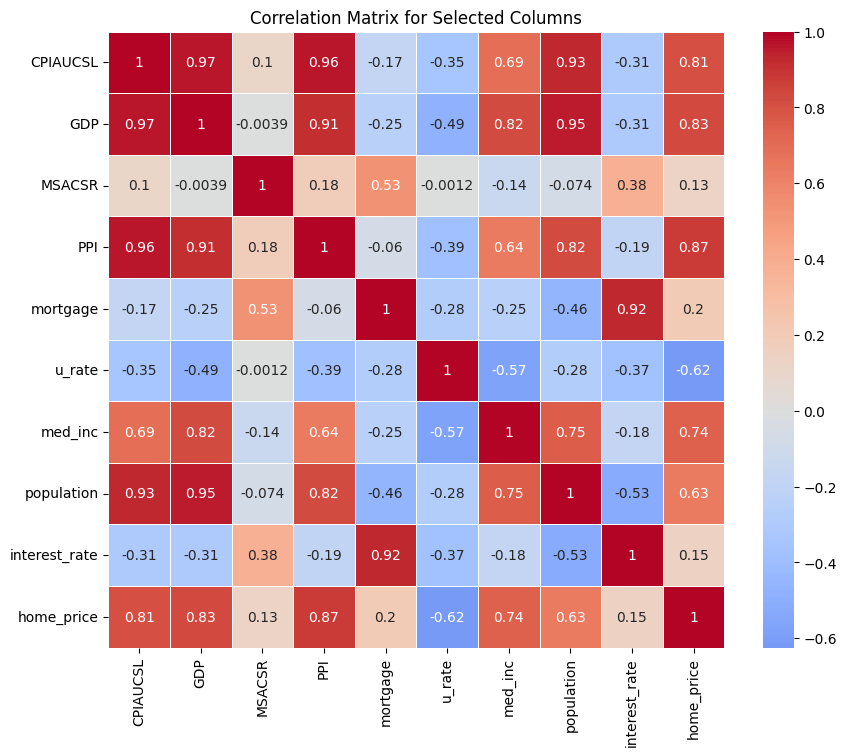

In [43]:
columns_to_include = ["CPIAUCSL","GDP",	"MSACSR",	"PPI","mortgage" ,"u_rate", "med_inc","population","interest_rate",	"home_price"]  # Modify this list with the columns you want
subset_df = df_1[columns_to_include]

# Calculate the correlation matrix for the selected columns
correlation_matrix = subset_df.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True, linewidths=.5)

# Display the plot
plt.title('Correlation Matrix for Selected Columns')
plt.show()

In [44]:
print("Column names in the DataFrame:", df_1.columns)

Column names in the DataFrame: Index(['DATE', 'home_price', 'GDP', 'MSACSR', 'PPI', 'CPIAUCSL', 'mortgage',
       'u_rate', 'med_inc', 'population', 'interest_rate'],
      dtype='object')


# **OLS**

In [45]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

# Drop the 'date' column
df_train=df_1.drop(columns=["DATE"])

# Assuming df is your DataFrame and 'home_price' is your target variable
X = df_train.drop(columns=['home_price'])
y = df_train['home_price']

# Add a constant to the features matrix (necessary for statsmodels)
X = sm.add_constant(X)

# Split data into training and testing sets (optional, for validation purposes)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the regression model using the training data
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the regression model to get R-squared and Adjusted R-squared
print(model.summary())

# Extract R-squared and Adjusted R-squared values
r_squared = model.rsquared
adj_r_squared = model.rsquared_adj

print(f'R-squared: {r_squared}')
print(f'Adjusted R-squared: {adj_r_squared}')

                            OLS Regression Results                            
Dep. Variable:             home_price   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     695.0
Date:                Sun, 09 Jun 2024   Prob (F-statistic):          7.29e-136
Time:                        14:53:17   Log-Likelihood:                -682.72
No. Observations:                 192   AIC:                             1385.
Df Residuals:                     182   BIC:                             1418.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           803.2687    114.741      7.001

# **RandomForest**

Mean Squared Error: 9.841408710183591
               importance
population       0.271366
CPIAUCSL         0.215762
med_inc          0.198497
PPI              0.191814
GDP              0.069615
u_rate           0.040730
mortgage         0.005163
interest_rate    0.003570
MSACSR           0.003482


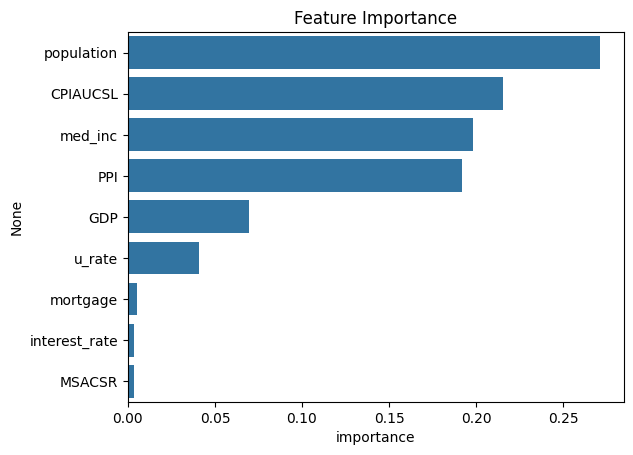

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Drop the 'date' column
df_train=df_1.drop(columns=["DATE"])

# Assuming df is your DataFrame and 'home_price' is your target variable
X = df_train.drop(columns=['home_price'])
y = df_train['home_price']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and calculate performance
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Feature importance
feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

print(feature_importances)

# Visualize feature importance
sns.barplot(x=feature_importances.importance, y=feature_importances.index)
plt.title('Feature Importance')
plt.show()

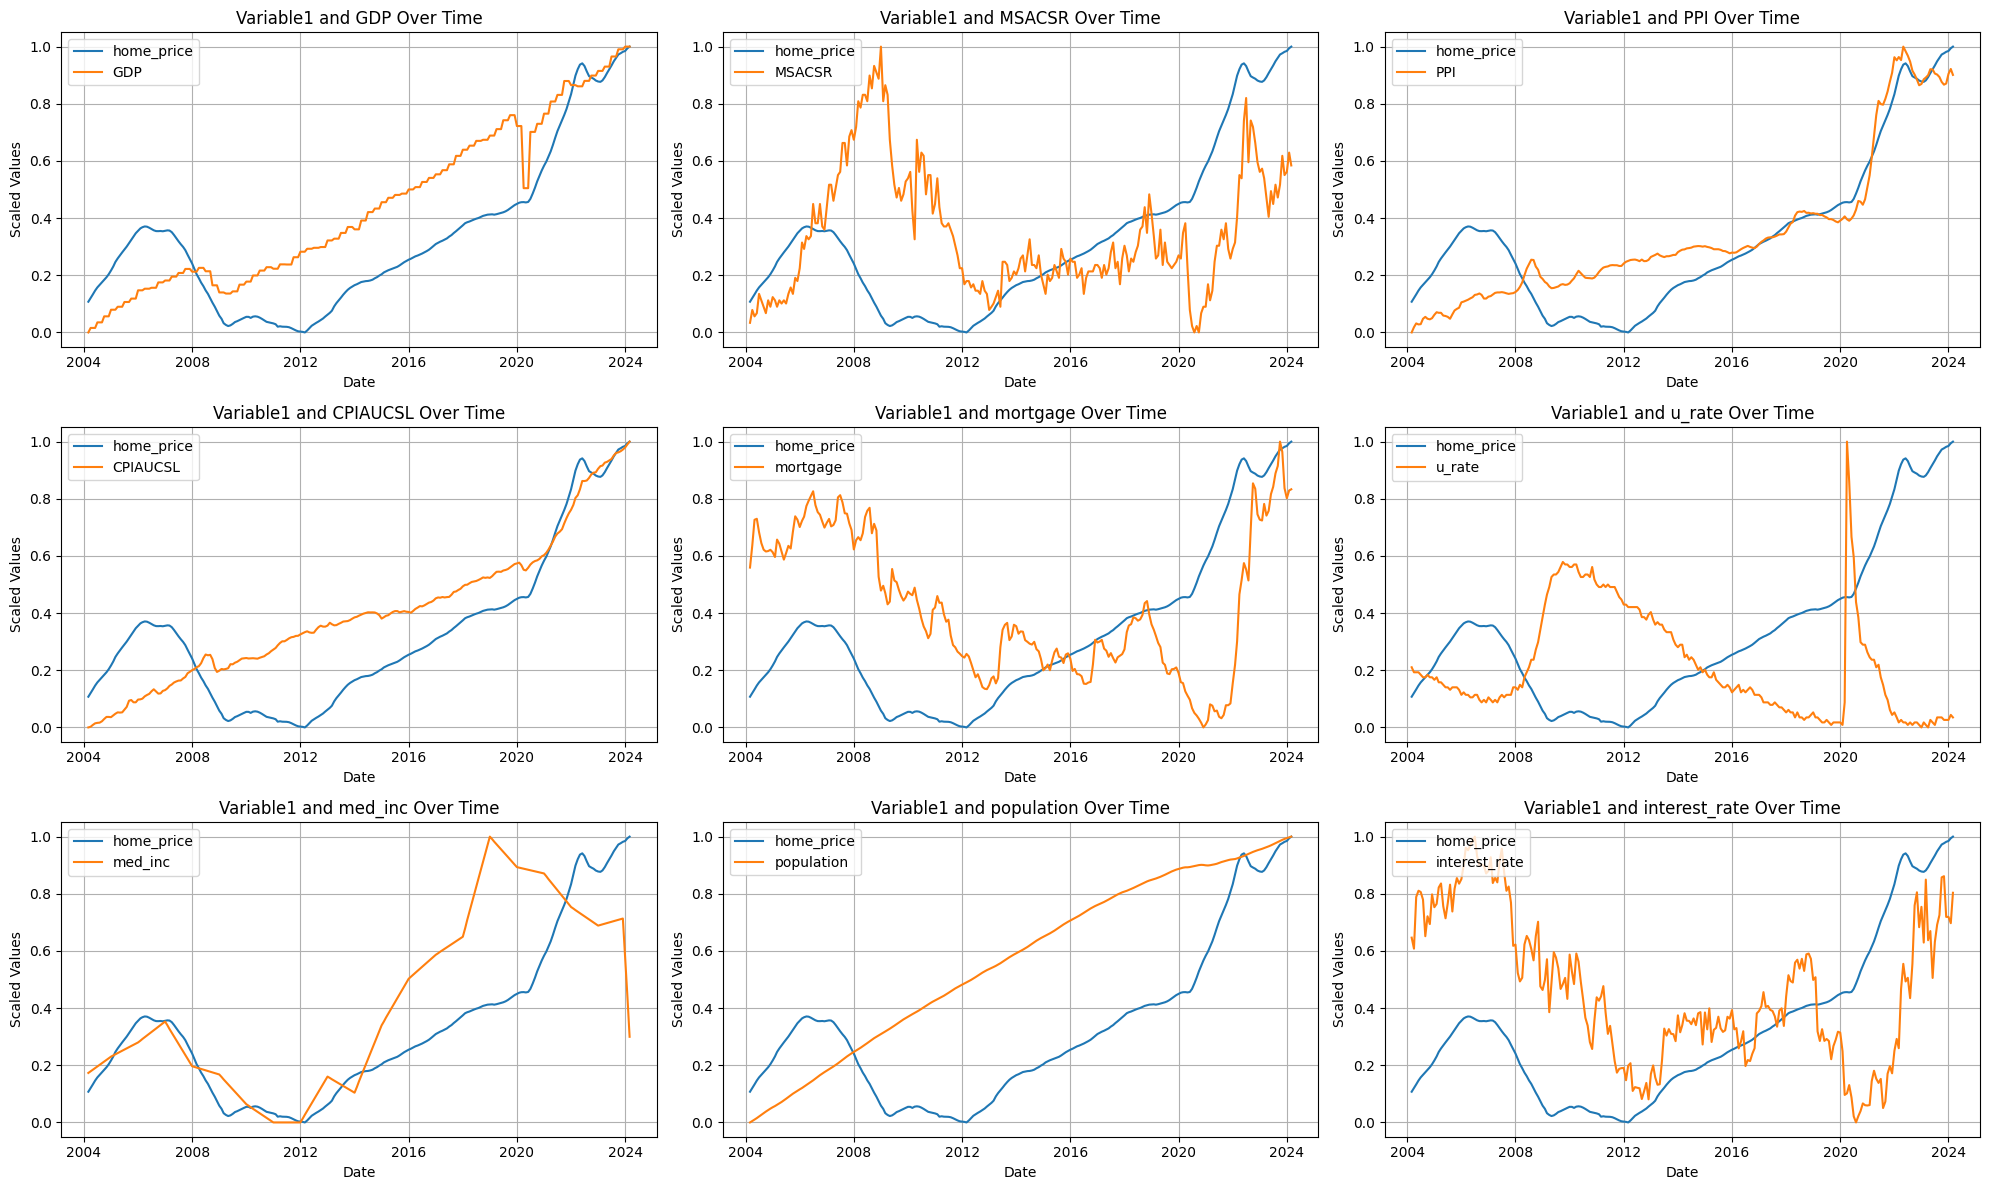

In [47]:
df_1["DATE"] = pd.to_datetime(df_1["DATE"])

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Apply MinMaxScaler to the columns except the 'Date' column
scaled_values = scaler.fit_transform(df_1.drop(columns=["DATE"]))

# Create a new DataFrame with the scaled values and the original 'Date' column
scaled_df = pd.DataFrame(scaled_values, columns=df_1.columns[1:])
scaled_df.insert(0, "DATE", df_1["DATE"])

# Plotting
num_vars = len(scaled_df.columns) - 1
rows = 3  # Number of rows for subplots
cols = 3  # Number of columns for subplots

fig, axes = plt.subplots(rows, cols, figsize=(20, 12))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, column in enumerate(scaled_df.columns[2:], start=1):
    axes[i - 1].plot(scaled_df["DATE"], scaled_df["home_price"], label="home_price")
    axes[i - 1].plot(scaled_df["DATE"], scaled_df[column], label=column)
    axes[i - 1].set_xlabel("Date")
    axes[i - 1].set_ylabel("Scaled Values")
    axes[i - 1].set_title(f"Variable1 and {column} Over Time")
    axes[i - 1].legend(loc='upper left')
    axes[i - 1].grid(True)

# Remove any unused subplots
for j in range(i, rows * cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [48]:
# Save the model to a file
joblib_file = "random_forest_model.joblib"
joblib.dump(model, joblib_file)

# Load the model from the file
rf_model_loaded = joblib.load(joblib_file)

# Verify the model works by making a prediction
predictions = rf_model_loaded.predict(X_test)
print(predictions)

[204.66833136 171.67688457 310.70562057 268.28200842 319.69966381
 212.23828878 227.47294039 310.84005617 177.95773997 161.88407589
 177.52630441 264.42832355 304.47864694 275.22102369 141.78685086
 183.78835996 218.14717252 187.91180129 145.09001597 173.35378693
 203.74416459 190.68654628 153.38508831 203.17347365 215.75325362
 211.04986383 180.2843643  145.97983554 137.80879617 194.109932
 152.16142172 298.30891579 204.8301147  145.92304522 188.66070255
 172.33797691 140.48006993 214.98256489 182.76892095 320.00528775
 144.83250519 166.96932273 154.61310916 188.3197051  215.37307537
 145.67343196 305.81272481 200.30664169 213.78049939]


In [49]:
y_pred = rf_model_loaded.predict(X_test)

# Calculate the Mean Square Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Square Error: {mse}")

Mean Square Error: 9.841408710183591


In [50]:
# Example baseline model: Mean prediction
y_mean_pred = np.mean(y_train) * np.ones_like(y_test)
baseline_mse = mean_squared_error(y_test, y_mean_pred)
print(f"Baseline Mean Square Error: {baseline_mse}")

# Compare with baseline
improvement = (baseline_mse - mse) / baseline_mse * 100
print(f"Improvement over baseline: {improvement:.2f}%")

Baseline Mean Square Error: 2934.7966193228003
Improvement over baseline: 99.66%
